(0.0, 1.0)

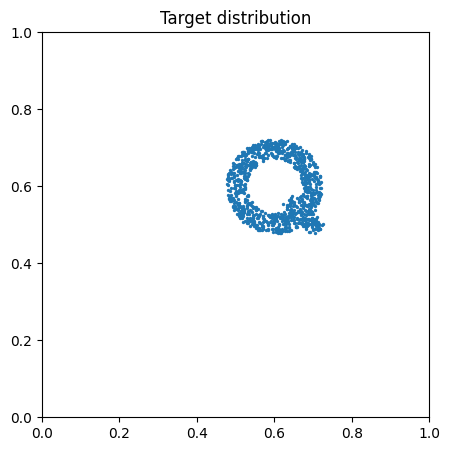

In [88]:
import importlib
import matplotlib.pyplot as plt
from modules import PointGenerator  # 초기 import
importlib.reload(PointGenerator)  # 모듈 갱신
import numpy as np
import pandas as pd

# 클래스 인스턴스 생성
data_num = 1000
idx = 1
pointgenerator = PointGenerator.PointGenerator(data_num)

generate_function = pointgenerator.generate_Q # 이걸 바꿔주면 된다.
data = generate_function()

# 그래프 그리기
plt.figure(figsize=(5, 5))
plt.scatter(data[:, 0], data[:, 1], s=2.0)
plt.title('Target distribution')
plt.xlim((0, 1))
plt.ylim((0, 1))

C:\Users\minkyu\AppData\Local\Temp\ipykernel_22820\3999429786.py:91: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load(f"{directory}/params/

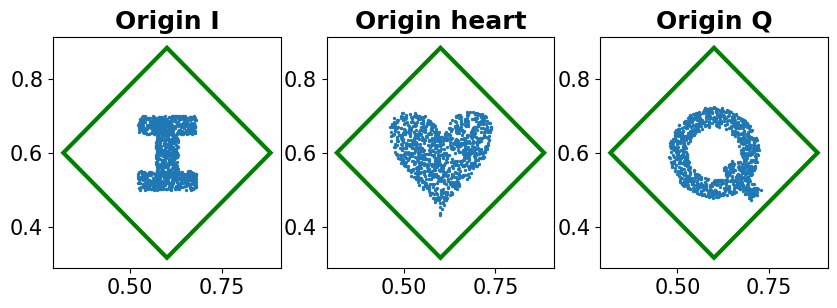

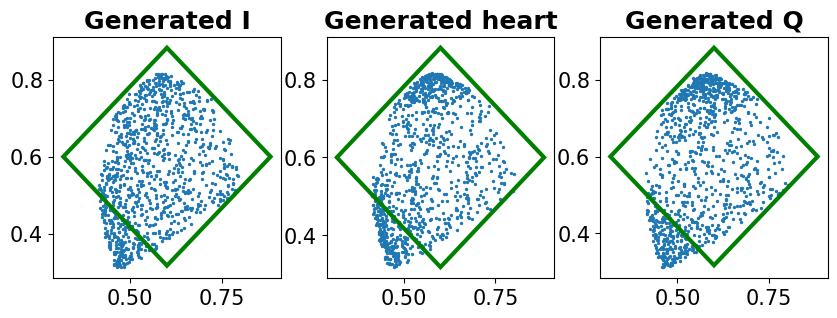

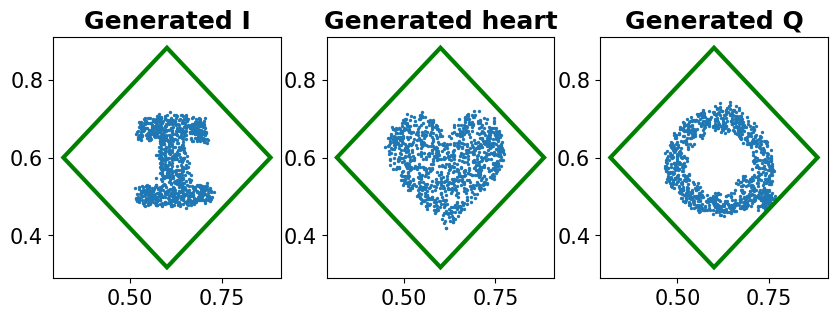

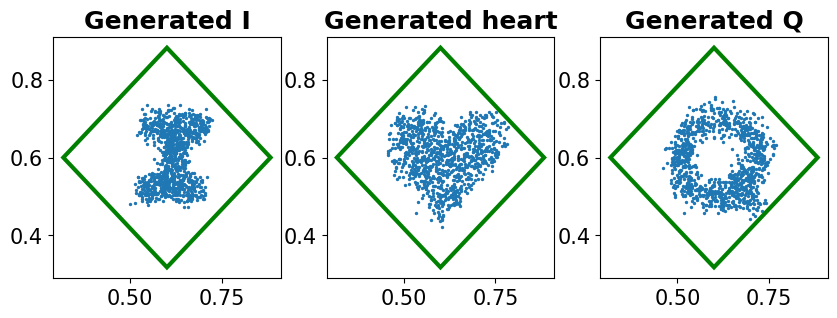

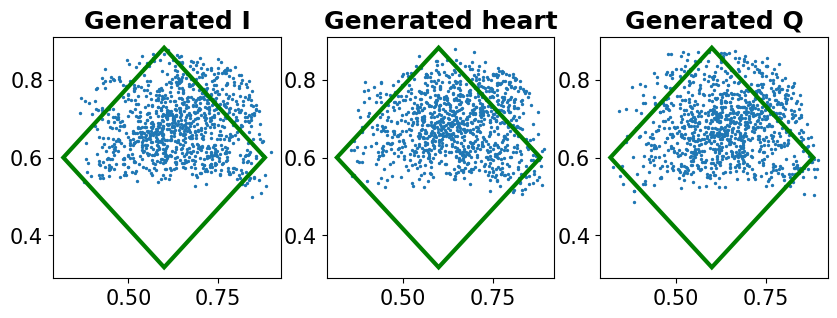

In [ ]:
# 대상 디렉터리와 모델 이름 리스트
from matplotlib import patches
from modules.Generator import LinearGeneratorSigmoid
from modules.QGenerator import QGenerator
from modules.utils import read_args
from tqdm import tqdm
import torch
import pennylane as qml


dirs = [
    ["./2d_results/GAN", "GAN"],
    ["./2d_results/InfoGAN", "InfoGAN"],
    ["./2d_results/InfoQGAN", "InfoQGAN"],
    ["./2d_results/QGAN", "QGAN"],
]
distribution_list = [
    [pointgenerator.generate_I, "I"],
    [pointgenerator.generate_heart, "heart"],
    [pointgenerator.generate_Q, "Q"],
]

def transform_data(origin_data, v1, v2):
    # Translate the data so that (0.6, 0.6) becomes the new origin
    shifted_data = origin_data - np.array([0.6, 0.6])
    # Construct the transformation matrix using v1 and v2 as column vectors
    A = np.column_stack((v1, v2))
    # Transform the data into the new coordinate system using the inverse of A
    transformed = shifted_data @ np.linalg.inv(A).T
    return transformed

# diamond shape patchs
arm = 0.2 * np.sqrt(2)
diamond_coords = [[0.6+arm, 0.6], [0.6, 0.6-arm], [0.6-arm, 0.6], [0.6, 0.6+arm]]

# draw origin data (1*3)
fig, axs = plt.subplots(1,3, figsize=(10, 3))
for i, (generate_function, code_name) in enumerate(distribution_list):
    origin_distribution = generate_function()
    axs[i].scatter(origin_distribution[:, 0], origin_distribution[:, 1], s=2.0)
    axs[i].add_patch(patches.Polygon(diamond_coords, closed=True, fill=False, edgecolor='green', linewidth=3))
    axs[i].set_title(f"Origin {code_name}", fontsize=18, fontweight='bold')
    axs[i].tick_params(axis='both', which='major', labelsize=15)
    axs[i].set_yticks([0.4, 0.6, 0.8])
#fig.suptitle(f"I love Q")
#fig.subplots_adjust(top=0.8)
plt.savefig(f"./2d_results/2d_custom_origin.png")

for directory, model in dirs:
    # 각 디렉터리의 scalars.csv 파일 읽기
    df = pd.read_csv(f"{directory}/scalars.csv")
    seed = read_args(f"{directory}/args.txt", "seed")[0]
    seed_dim, code_dim = read_args(f"{directory}/args.txt", "n_qubits", "code_qubits") if 'Q' in model else read_args(f"{directory}/args.txt", "seed_dim", "code_dim")
    
    # p_value가 가장 높은 행 찾기
    max_row = df.loc[df["p_value"].idxmax()]
    best_epoch = int(max_row["epoch"])

    code1_vec = np.array([max_row["Corr/code0-x"], max_row["Corr/code0-y"]])
    code2_vec = np.array([max_row["Corr/code1-x"], max_row["Corr/code1-y"]])
    code1_norm = np.linalg.norm(code1_vec)
    code2_norm = np.linalg.norm(code2_vec)
    code1_vec *= (0.2 / code1_norm / seed)
    code2_vec *= (0.2 / code2_norm / seed)

    total_output = []

    for generate_function, code_name in distribution_list:
        origin_distribution = generate_function()
        transformed_distribution = transform_data(origin_distribution, code1_vec, code2_vec)

        generated_output = []
        generator_input = np.random.uniform(-seed, seed, (data_num, seed_dim))
        generator_input[:, -code_dim:] = transformed_distribution

        if 'Q' in model: # quantum generator
            n_layers = read_args(f"{directory}/args.txt", "n_layers")[0]
            qml_device = qml.device("lightning.qubit", wires=seed_dim) # for faster simulation
            generator_initial_params = torch.load(f"{directory}/params/generator_params_epoch{best_epoch}.pth", weights_only=True)
            generator = QGenerator(seed_dim, 2, n_layers, generator_initial_params, qml_device, entangling = "CNOT")
            for i in tqdm(range(data_num)):
                with torch.no_grad():
                    z = torch.tensor(generator_input[i]).float().unsqueeze(0)
                    output_probs =  generator.forward(z).numpy().flatten()
                    output = [sum(output_probs[i] for i in range(len(output_probs)) if (i >> bit) & 1) for bit in range(2)]
                    generated_output.append(output)
        
        else: # classical generator
            hidden_dim = read_args(f"{directory}/args.txt", "hidden_dim")[0]
            generator = LinearGeneratorSigmoid(input_dim=seed_dim, output_dim=2, hidden_size=hidden_dim)
            generator.load_state_dict(torch.load(f"{directory}/params/generator_params_epoch{best_epoch}.pth"))
            for i in tqdm(range(data_num)):
                with torch.no_grad():
                    z = torch.tensor(generator_input[i]).float().unsqueeze(0)
                    output =  generator.forward(z).numpy().flatten()
                    generated_output.append(output)
        
        generated_output = np.array(generated_output).reshape(-1, 2)
        # draw target distribution, code distribution, generated_distribution
        
        fig, axs = plt.subplots(1,3, figsize=(10, 3.5))

        
        axs[0].scatter(origin_distribution[:, 0], origin_distribution[:, 1], s=2.0)
        axs[0].add_patch(patches.Polygon(diamond_coords, closed=True, fill=False, edgecolor='green', linewidth=3))
        axs[0].set_title('Target distribution')
        axs[1].scatter(transformed_distribution[:, 0], transformed_distribution[:, 1], s=2.0)
        axs[1].set_title('code space')
        axs[1].set_xlim(-seed*1.2, seed*1.2)
        axs[1].set_ylim(-seed*1.2, seed*1.2)
        axs[2].scatter(generated_output[:, 0], generated_output[:, 1], s=2.0)
        axs[2].add_patch(patches.Polygon(diamond_coords, closed=True, fill=False, edgecolor='green', linewidth=3))
        axs[2].set_title('Generated distribution')

        # set title
        fig.suptitle(f"{model}")
        fig.subplots_adjust(top=0.8)
        plt.savefig(f"./2d_results/{model}_{code_name}.png")
        plt.close()

        total_output.append(generated_output)

    # draw all generated distributions (1 * 3)
    fig, axs = plt.subplots(1,3, figsize=(10, 3.5))
    for i, (generated_output, code_name) in enumerate(zip(total_output, ["I", "heart", "Q"])):
        axs[i].scatter(generated_output[:, 0], generated_output[:, 1], s=2.0)
        axs[i].add_patch(patches.Polygon(diamond_coords, closed=True, fill=False, edgecolor='green', linewidth=3))
        axs[i].set_title(f"Generated {code_name}", fontsize=18, fontweight='bold')
        axs[i].tick_params(axis='both', which='major', labelsize=15)
        axs[i].set_yticks([0.4, 0.6, 0.8])
    fig.subplots_adjust(top=0.8)
    plt.savefig(f"./2d_results/2d_custom_{model}_all.png")